# Simple linear regression - Metropolis

# _Josep Fortiana_   $\hskip3cm$  2022-05-09

***
###### LaTeX macros
$ \def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\Var{\operatorname{Var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\cauchydist{\operatorname{Cauchy}}$
$\def\dexpdist{\operatorname{DExp}}$
$\def\expdist{\operatorname{Exp}}$
$\def\fdist{\operatorname{F}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\halfcauchydist{\operatorname{Cauchy}^{+}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\invgammadist}{IG}$
$\def\laplacedist{\operatorname{Laplace}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\normaldist{\operatorname{N}}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\tdist{\operatorname{t}}$
$\def\unifdist{\operatorname{Unif}}$
$\def\xbar{\kern1.3pt\overline{\kern-1.3pt x}}$
$\def\Xbar{\kern1.3pt\overline{\kern-1.3pt X}}$
$\def\yhat{\kern1.3pt\hat{\kern-1.3pt y}}$
$\def\betahat{\kern1.3pt\hat{\kern-1.3pt \beta}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
$\def\eqdef{\stackrel{\text{def}}{\mskip3mu=\mskip3mu}}$
***

# Exercise

Prepare and run a Metropolis MCMC simulation for a simple least squares regression model.

This exercise closely follows the explanatory text and R scripts in [Florian Hartig's blog.](https://theoreticalecology.wordpress.com/2010/09/17/metropolis-hastings-mcmc-in-r/)

It is advisable to work in parallel, performing computations here and reading the blog explanations.

Warning: I switched labels `a` and `b` for intercept and slope from Hartig's notation.

## Creating test data

In [1]:
set.seed(24025)
trueA<-0  # R notation for abline: b is the slope
trueB<-5
trueSd<-10
sampleSize<-31
# create independent x-values 
x<-(-(sampleSize-1)/2):((sampleSize-1)/2)
# create dependent values according to a + b*x + N(0,sd)
y<-trueA+trueB*x+rnorm(n=sampleSize,mean=0,sd=trueSd)

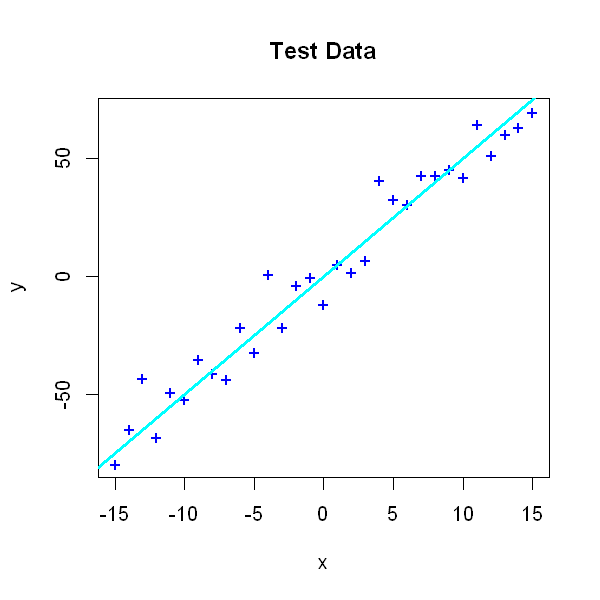

In [2]:
options(repr.plot.width=5,repr.plot.height=5)
plot(x,y,pch='+',col="blue",main="Test Data")
abline(trueA,trueB,lwd=2.5,col="cyan")

## Fit a classical linear model

Assuming the common standard deviation is a known constant.

In [3]:
lm.1<-lm(y~x)
summary(lm.1)
a.hat<-as.numeric(lm.1$coefficients[1])
b.hat<-as.numeric(lm.1$coefficients[2])


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-12.743  -7.732  -0.552   5.520  20.432 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.2031     1.6579   0.726    0.474    
x             4.7915     0.1854  25.851   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.231 on 29 degrees of freedom
Multiple R-squared:  0.9584,	Adjusted R-squared:  0.957 
F-statistic: 668.3 on 1 and 29 DF,  p-value: < 2.2e-16


In [4]:
lm.1.anova<-anova(lm.1)
lm.1.anova
# str(lm.1.anova)
sigma2.hat<-lm.1.anova$Sum[2]/lm.1.anova$Df[2]
sigma.hat<-sqrt(sigma2.hat)
sprintf("Estimated intercept = %f",round(a.hat,3))
sprintf("Estimated slope = %f",round(b.hat,3))
sprintf("Estimated std. deviation = %f",round(sigma.hat,3))

Df Sum Sq    Mean Sq     F value  Pr(>F)      
x          1 56938.147 56938.14661 668.2632 1.416233e-21
Residuals 29  2470.892    85.20318       NA           NA

[1] "Estimated intercept = 1.203000"

[1] "Estimated slope = 4.792000"

[1] "Estimated std. deviation = 9.231000"

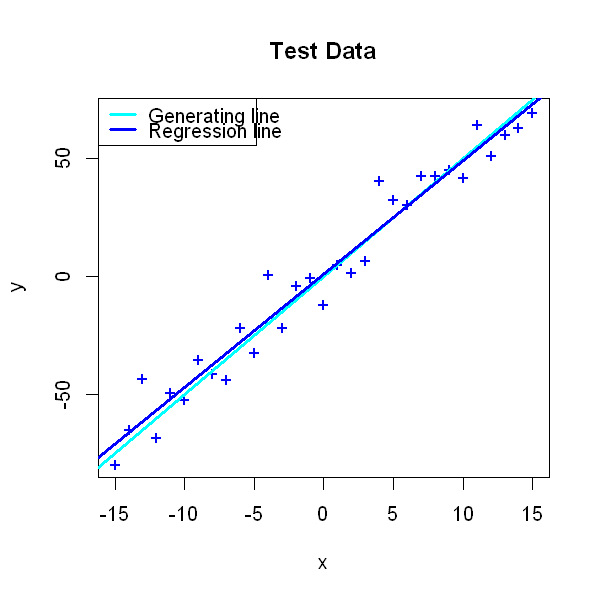

In [5]:
options(repr.plot.width=5,repr.plot.height=5)
plot(x,y,pch='+',col="blue",main="Test Data")
abline(trueA,trueB,lwd=2.5,col="cyan")
abline(lm.1,lwd=2.5,col="blue")
legend("topleft",c("Generating line","Regression line"), lwd=2.5,col=c("cyan","blue"))

## Log-Likelihood

We assume a normal linear model, that is, each observation $y_i\sim\operatorname{N}(a+b\cdot x_i,\sigma^2)$. 

Parameters are $a$ (intercept), $b$ (slope) and the common standard deviation $\sigma$.

In [6]:
log.likelihood <- function(param){
    a<-param[1]
    b<-param[2]
    sd<-param[3]
    pred<-a+b*x
    singleloglikelihoods = dnorm(y,mean=pred,sd=sd,log=TRUE)
    sumll<-sum(singleloglikelihoods)
    return(sumll)   
    }

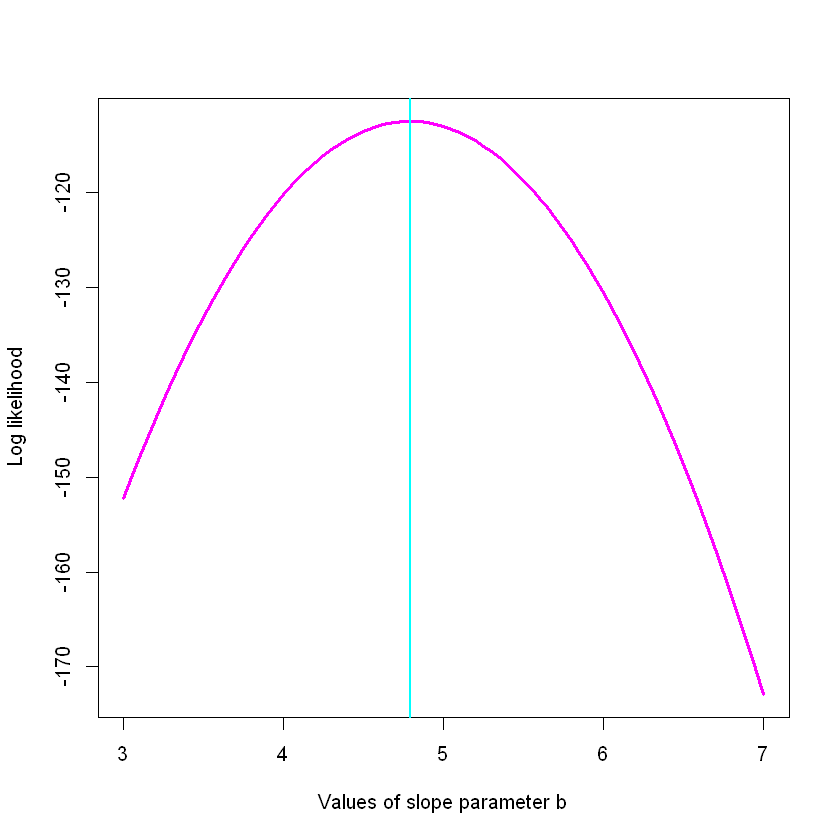

In [7]:
# Example: plot the loglikelihood profile of the slope b
slopevalues<-function(b){return(log.likelihood(c(trueA,b,trueSd)))}
slopelikelihoods<-lapply(seq(3,7,by=0.05),slopevalues)
options(repr.plot.width=7,repr.plot.height=7)
plot(seq(3,7,by=0.05),slopelikelihoods,type="l",lwd=2.5,col="magenta",xlab="Values of slope parameter b", 
     ylab="Log likelihood")
abline(v=b.hat,col="cyan",lwd=2.0) # Max likelihood estimator of b

## Prior

- Normal prior for the intercept, with mean=0 and sd=5.
- Uniform(0,10) for the slope.
- Uniform(0,30) for the sd parameter.

In [8]:
log.prior <- function(param){
    a<-param[1]
    b<-param[2]
    sd<-param[3]
    aprior<-dnorm(a,mean=0,sd=5,log=TRUE)
    bprior<-dunif(b,min=0,max=10,log=TRUE)
    sdprior<-dunif(sd, min=0, max=30, log = TRUE)
    return(aprior+bprior+sdprior)
    }

## Unnormalized log-posterior

In [9]:
log.posterior <- function(param){
    return (log.likelihood(param)+log.prior(param))
    }

## Proposal function for the Metropolis algorithm

A normal pdf for each of the three parameters.

The standard deviations should be decided by trial and error.

In [10]:
proposalfunction <- function(param){
    return(rnorm(3,mean = param, sd= c(0.5,0.1,0.3)))
    }

## Metropolis chain generation

In [11]:
metropolis_MCMC <- function(startvalue, iterations){
    chain<-array(dim = c(iterations+1,3))
    chain[1,]<-startvalue
    for (i in 1:iterations){
        proposal<-proposalfunction(chain[i,])
        probab<-exp(log.posterior(proposal) - log.posterior(chain[i,]))
        if (runif(1)<probab)
            chain[i+1,]<-proposal
        else
            chain[i+1,]<-chain[i,]
        }
    return(chain)
    }

## Run simulation 

- Decide chain length and `burnIn`

- Run simulation and discard first `burnIn` values

- Compute the acceptance rate

In [12]:
#ChainLength<-10000
ChainLength<-50000
startvalue<-c(0,4,10)
chain<-metropolis_MCMC(startvalue,ChainLength)
# 
#burnIn<-5000
burnIn<-10000
acceptance<-1-mean(duplicated(chain[-(1:burnIn),]))
round(acceptance,3)

[1] 0.77

## Posterior histograms

With superimposed red vertical lines indicating "True" values (i.e., values originally used for generating the sample), and cyan vertical lines indicating estimated values, the LS=ML estimates obtained from the classical linear model adjustment.

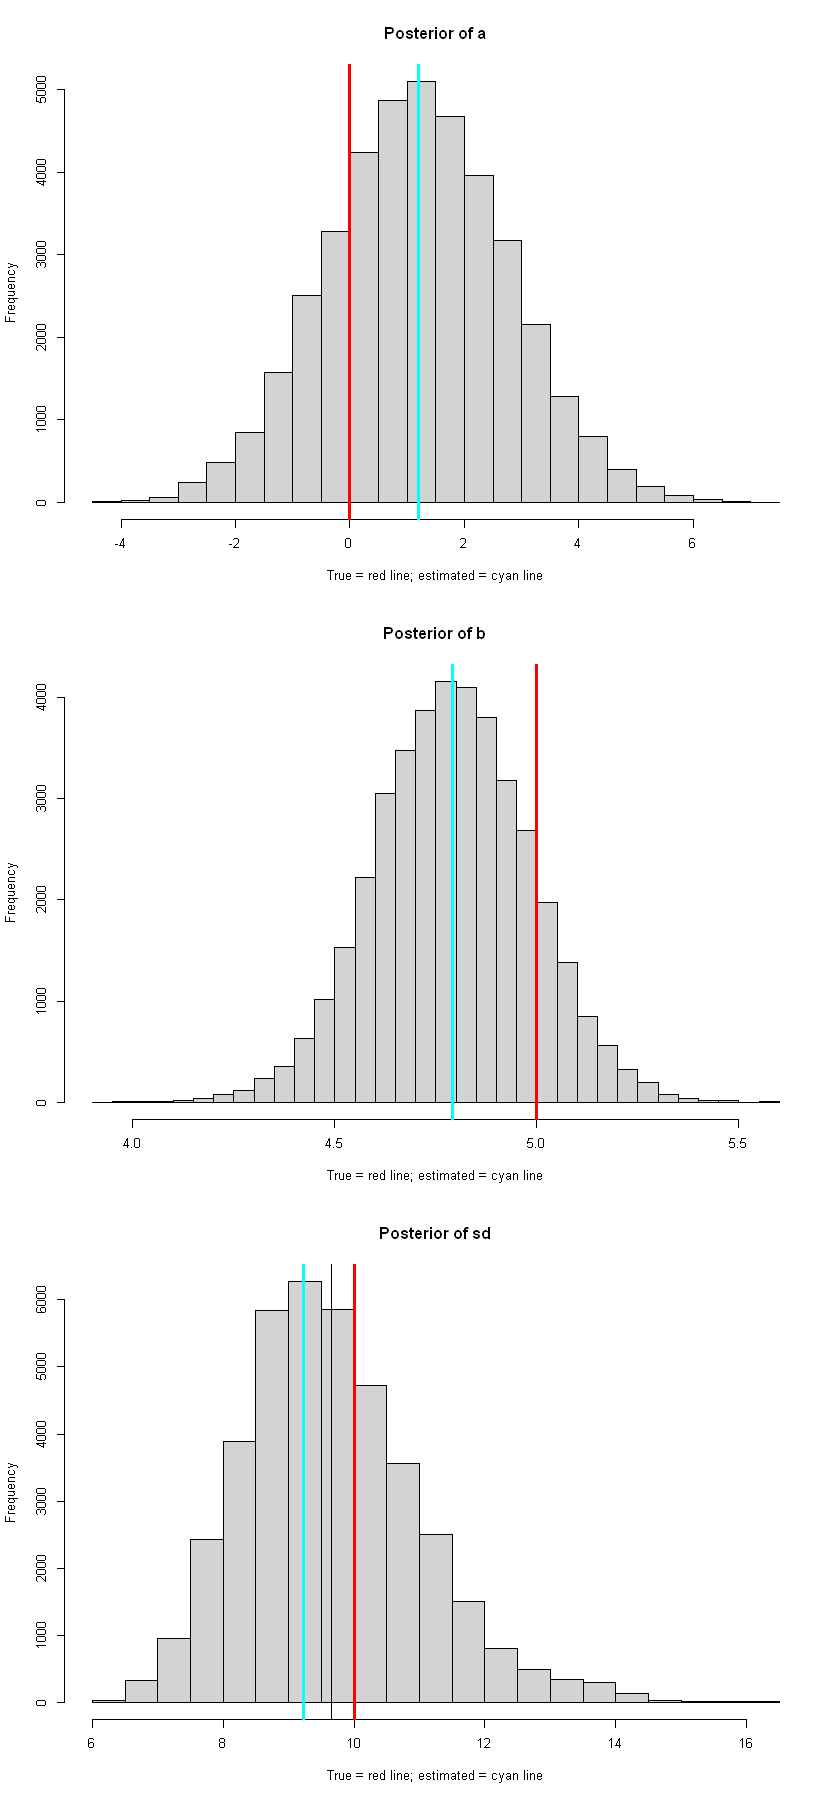

In [13]:
options(repr.plot.width=7,repr.plot.height=15)
old.par<-par(mfrow = c(3,1))
hist(chain[-(1:burnIn),1],nclass=30, , main="Posterior of a", xlab="True = red line; estimated = cyan line")
abline(v = mean(chain[-(1:burnIn),1]),lwd=2.5)
abline(v = trueA,lwd=2.5, col="red")
abline(v=a.hat,lwd=2.5,col="cyan")
hist(chain[-(1:burnIn),2],nclass=30, main="Posterior of b", xlab="True = red line; estimated = cyan line")
abline(v = mean(chain[-(1:burnIn),2]))
abline(v = trueB,lwd=2.5, col="red")
abline(v=b.hat,lwd=2.5,col="cyan")
hist(chain[-(1:burnIn),3],nclass=30, main="Posterior of sd", xlab="True = red line; estimated = cyan line")
abline(v = mean(chain[-(1:burnIn),3]))
abline(v = trueSd,lwd=2.5, col="red" )
abline(v = sigma.hat,lwd=2.5, col="cyan")
par(old.par)

## Traceplot

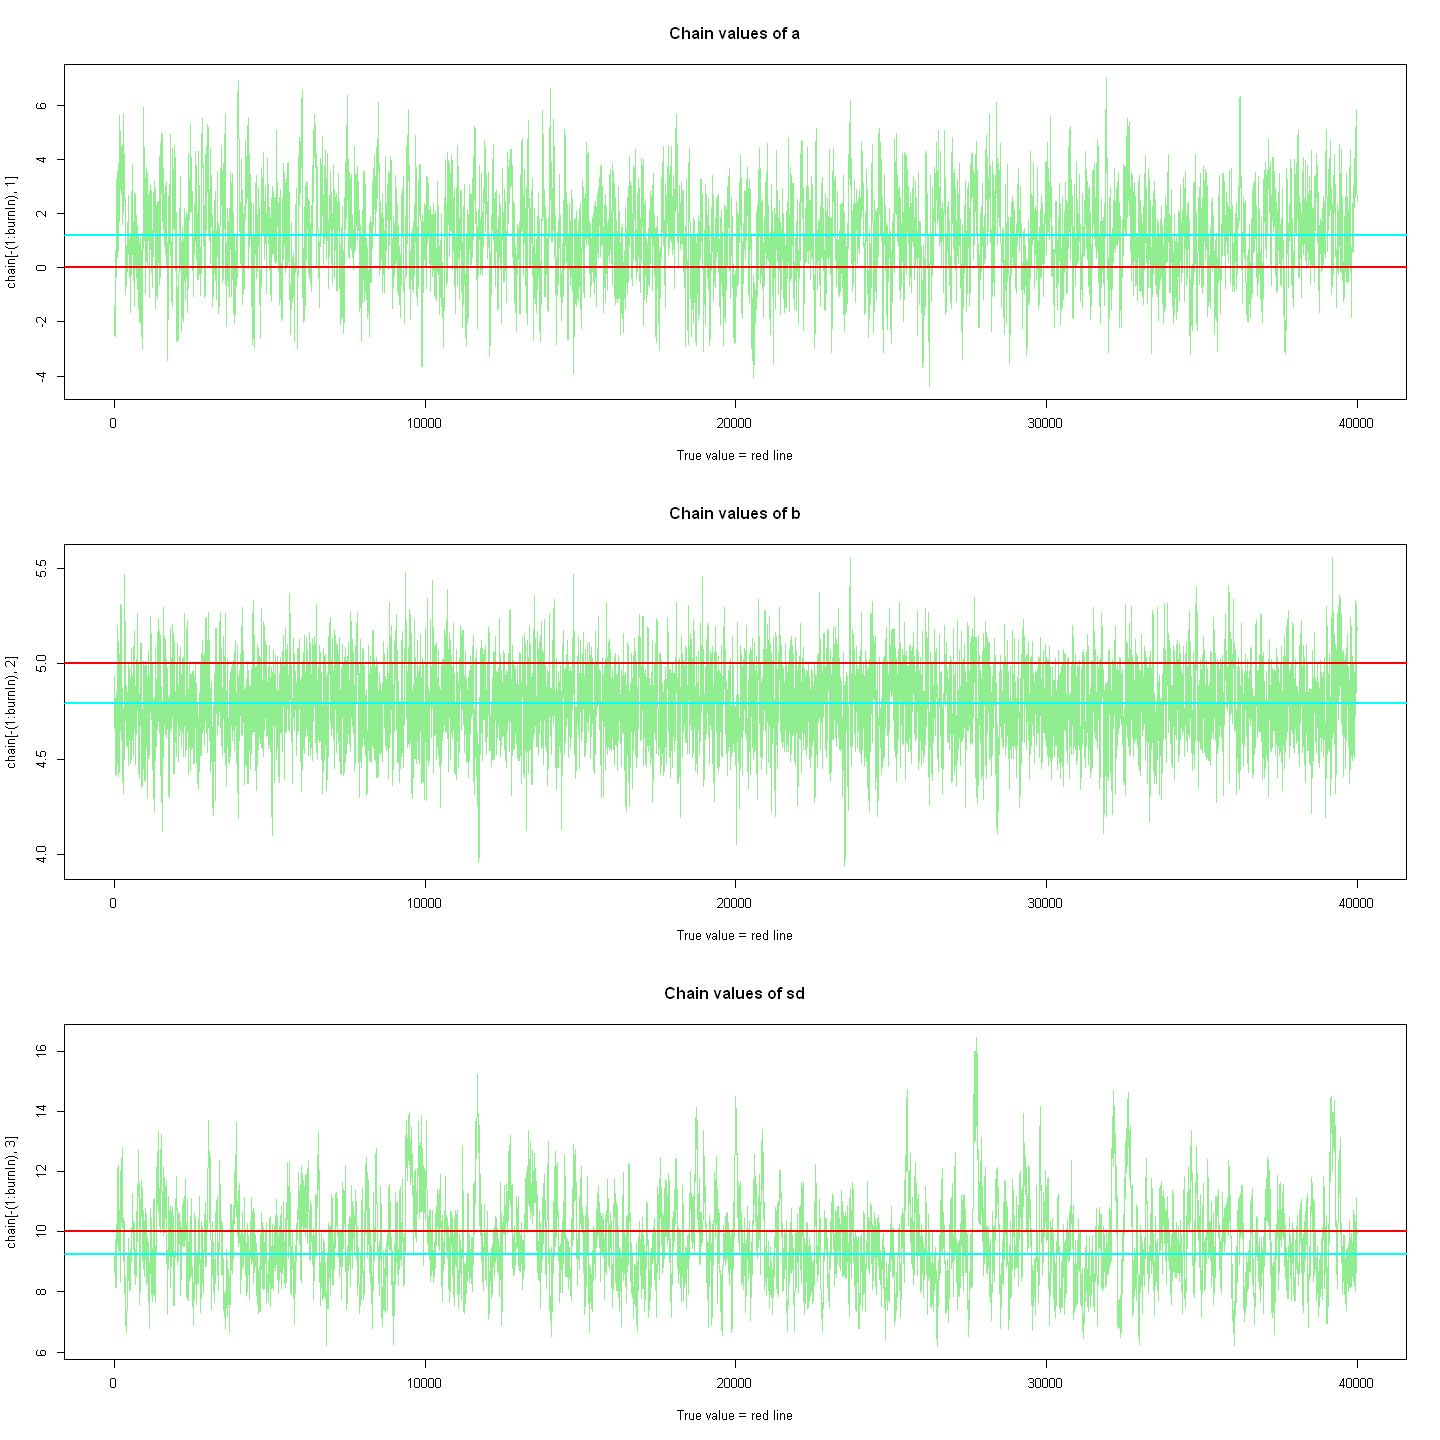

In [15]:
options(repr.plot.width=12,repr.plot.height=12)
old.par<-par(mfrow = c(3,1))
plot(chain[-(1:burnIn),1], type = "l", xlab="True value = red line",col="LightGreen",lwd=1,main = "Chain values of a", )
abline(h=trueA,lwd=2.0,col="red")
abline(h=a.hat,lwd=2.0,col="cyan")
plot(chain[-(1:burnIn),2], type = "l", xlab="True value = red line",col="LightGreen",lwd=1,main = "Chain values of b", )
abline(h=trueB,lwd=2.0,col="red")
abline(h=b.hat,lwd=2.0,col="cyan")
plot(chain[-(1:burnIn),3], type = "l", xlab="True value = red line",col="LightGreen",lwd=1,main = "Chain values of sd", )
abline(h=trueSd,lwd=2.0,col="red")
abline(h=sigma.hat,lwd=2.0,col="cyan")
par(old.par) 

In [17]:
require(coda)

Loading required package: coda



In [18]:
simple.regression.m0.mcmc<-as.mcmc(chain[-(1:burnIn),])
dimnames(simple.regression.m0.mcmc)<-list(NULL,c("a","b","sigma"))

In [19]:
str(simple.regression.m0.mcmc)

 'mcmc' num [1:40001, 1:3] -1.6 -1.68 -1.39 -1.39 -2.37 ...
 - attr(*, "mcpar")= num [1:3] 1 40001 1
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:3] "a" "b" "sigma"


In [20]:
summary(simple.regression.m0.mcmc)


Iterations = 1:40001
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 40001 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean     SD  Naive SE Time-series SE
a     1.193 1.5677 0.0078386       0.058217
b     4.790 0.1927 0.0009636       0.004639
sigma 9.661 1.3554 0.0067768       0.071268

2. Quantiles for each variable:

        2.5%    25%   50%    75%  97.5%
a     -1.854 0.1289 1.186  2.255  4.296
b      4.411 4.6605 4.790  4.920  5.170
sigma  7.395 8.7149 9.523 10.466 12.798
